# This network demonstrates how to use LIME with recurrent neural networks.

This focuses on keras-style "stateless" recurrent neural networks. These networks expect input with a shape `(n_samples, n_timesteps, n_features)` as opposed to the more normal `(n_samples, n_features)` input that most other machine learning algorithms expect. 

To explain the neural network models, we use a variant on the `TabularExplainer` that takes care of reshaping data appropriately.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

%matplotlib inline

Using TensorFlow backend.


## Data

We will use the $CO_2$ dataset, which measures the concentration of $CO_2$ above Mauna Loa every week since about 1960. The classification task will be deciding if the concentration is rising - this is a problem that needs recurrency to solve (since the answer comes from the derivative), and is less trivial than it sounds because there is noise in the data. 

The data is included in the `data` subdirectory here, where I've added a column for the detrended data that ends up being useful for the network, as we shall see shortly.

In [2]:
df = pd.read_csv('data/co2_data.csv', index_col=0, parse_dates=True)

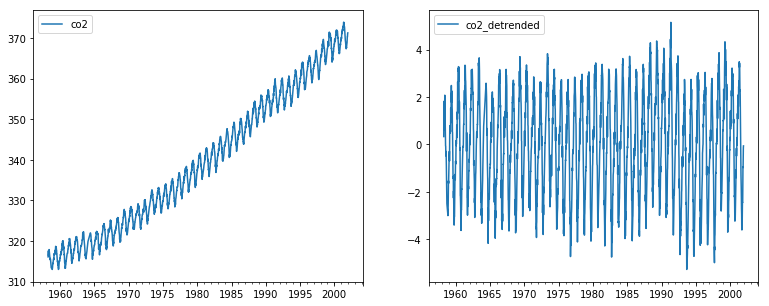

In [3]:
fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
df[['co2']].plot(ax=left)
df[['co2_detrended']].plot(ax=right)

### Reshaping the dataset to be appropriate for the model

In [4]:
def reshape_data(seq, n_timesteps):
    N = len(seq) - n_timesteps - 1
    nf = seq.shape[1]
    if N <= 0:
        raise ValueError('I need more data!')
    new_seq = np.zeros((N, n_timesteps, nf))
    for i in range(N):
        new_seq[i, :, :] = seq[i:i+n_timesteps]
    return new_seq

In [5]:
N_TIMESTEPS = 12  # Use 1 year of lookback
data_columns = ['co2', 'co2_detrended']
target_columns = ['rising']

scaler = MinMaxScaler(feature_range=(-1, 1))
X_original = scaler.fit_transform(df[data_columns].values)
X = reshape_data(X_original, n_timesteps=N_TIMESTEPS)
y = to_categorical((df[target_columns].values[N_TIMESTEPS:-1]).astype(int))

# Train on the first 2000, and test on the last 276 samples
X_train = X[:2000]
y_train = y[:2000]
X_test = X[2000:]
y_test = y[2000:]
print(X.shape, y.shape)

(2270, 12, 2) (2270, 2)


# Define the model

In [6]:
model = Sequential()
model.add(LSTM(32, input_shape=(N_TIMESTEPS, len(data_columns))))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [7]:
model.fit(X_train, y_train, batch_size=100, epochs=500,
          validation_data=(X_test, y_test),
          verbose=2)

Train on 2000 samples, validate on 270 samples
Epoch 1/500
 - 4s - loss: 0.6868 - val_loss: 0.6830
Epoch 2/500
 - 1s - loss: 0.6730 - val_loss: 0.6764
Epoch 3/500
 - 1s - loss: 0.6618 - val_loss: 0.6697
Epoch 4/500
 - 1s - loss: 0.6492 - val_loss: 0.6630
Epoch 5/500
 - 1s - loss: 0.6381 - val_loss: 0.6559
Epoch 6/500
 - 1s - loss: 0.6260 - val_loss: 0.6483
Epoch 7/500
 - 1s - loss: 0.6126 - val_loss: 0.6402
Epoch 8/500
 - 1s - loss: 0.5991 - val_loss: 0.6305
Epoch 9/500
 - 0s - loss: 0.5842 - val_loss: 0.6203
Epoch 10/500
 - 1s - loss: 0.5663 - val_loss: 0.6080
Epoch 11/500
 - 1s - loss: 0.5488 - val_loss: 0.5949
Epoch 12/500
 - 1s - loss: 0.5278 - val_loss: 0.5791
Epoch 13/500
 - 1s - loss: 0.5058 - val_loss: 0.5612
Epoch 14/500
 - 1s - loss: 0.4849 - val_loss: 0.5415
Epoch 15/500
 - 1s - loss: 0.4582 - val_loss: 0.5200
Epoch 16/500
 - 1s - loss: 0.4364 - val_loss: 0.4985
Epoch 17/500
 - 1s - loss: 0.4137 - val_loss: 0.4765
Epoch 18/500
 - 1s - loss: 0.3918 - val_loss: 0.4549
Epoch 19

Epoch 154/500
 - 1s - loss: 0.1945 - val_loss: 0.2448
Epoch 155/500
 - 1s - loss: 0.1923 - val_loss: 0.2476
Epoch 156/500
 - 1s - loss: 0.1961 - val_loss: 0.2470
Epoch 157/500
 - 1s - loss: 0.1938 - val_loss: 0.2480
Epoch 158/500
 - 1s - loss: 0.1918 - val_loss: 0.2472
Epoch 159/500
 - 1s - loss: 0.1921 - val_loss: 0.2455
Epoch 160/500
 - 1s - loss: 0.1930 - val_loss: 0.2489
Epoch 161/500
 - 0s - loss: 0.1945 - val_loss: 0.2448
Epoch 162/500
 - 0s - loss: 0.1961 - val_loss: 0.2453
Epoch 163/500
 - 1s - loss: 0.1898 - val_loss: 0.2446
Epoch 164/500
 - 1s - loss: 0.1945 - val_loss: 0.2433
Epoch 165/500
 - 1s - loss: 0.1906 - val_loss: 0.2444
Epoch 166/500
 - 1s - loss: 0.1959 - val_loss: 0.2459
Epoch 167/500
 - 1s - loss: 0.1939 - val_loss: 0.2433
Epoch 168/500
 - 1s - loss: 0.1943 - val_loss: 0.2459
Epoch 169/500
 - 1s - loss: 0.1916 - val_loss: 0.2456
Epoch 170/500
 - 1s - loss: 0.1926 - val_loss: 0.2440
Epoch 171/500
 - 1s - loss: 0.1957 - val_loss: 0.2438
Epoch 172/500
 - 1s - loss: 

KeyboardInterrupt: 

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

In [ ]:
plt.plot(y_true, lw=3, alpha=0.3, label='Truth')
plt.plot(y_pred, '--', label='Predictions')
plt.legend(loc='best')

# Explain the model with LIME:

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=data_columns,
                                                   discretize_continuous=True,
                                                   class_names=['Falling', 'Rising'],
                                                   discretizer='decile')

In [ ]:
exp = explainer.explain_instance(X_test[50], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

We can see that the most important features are the de-trended $CO_2$ concentration several timesteps in the past. In particular, we see that if that feature is low in the recent past, then the concentration is now probably rising. 